# Machine learning model to read reviews

Question: how can we analyze a large number or reviews with NPL?

Goal: enable companies to quickly extract the key topics covered from the customer feedback without having to read through them one by one

In [1]:
# 1 Import dependencies
from sqlalchemy import create_engine
import pandas as pd
import spacy

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim_models
%matplotlib inline

# Libraries for lemmatization
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import FreqDist

# Libraries for word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# 2 Postgres username, password, and database name
POSTGRES_ADDRESS = 'mypostgresdb.cwuhtytzosg8.us-east-2.rds.amazonaws.com' 
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'root' 
POSTGRES_PASSWORD = 'XXXX' ## CHANGE THIS TO YOUR PANOPLY/POSTGRES PASSWORD
POSTGRES_DBNAME = 'my_data_class_db'
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
.format(username=POSTGRES_USERNAME,
password=POSTGRES_PASSWORD,
ipaddress=POSTGRES_ADDRESS,
port=POSTGRES_PORT,
dbname=POSTGRES_DBNAME))
# Create the connection
cnx = create_engine(postgres_str)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# 3 Load database for sentiment/topic analysis
df = pd.read_sql_query('''SELECT * FROM airmattress_cleaned_v2''', con=cnx)
df.head()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,review_id,star_rating,review_body
0,46619816,R3A3BMMWFE53L7,2,i wouldnt really recommend this to anyone i sl...
1,44543268,ROHMHI9495XEX,5,we bought this to use in our cottage for overf...
2,41744720,R1Z8PESIUO0LP9,5,buenos dias todo llego en excelente estado un ...
3,28904296,R3O69V6PAADOYQ,5,smaller than the standard bed but just as elev...
4,35675695,R2ESZJ83S1SZE6,2,bought this for the occasional guest the firs...


### Prepare data for ML model

In [4]:
# 4 To remove noise from reviews, use lemmatization from spaCy library
!python -m spacy download en_core_web_sm 

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2021-05-20 18:09:24.593818: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-05-20 18:09:24.593849: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


It will be easier to understand good and bad customer feedback if we break the analysis into good reviews and bad reviews

### Develop 2 separate analysis: good reviews from bad reviews

Create 2 dataframes, one with only 1 star reviews and another with 2 star reviews to get a better sense of the good and bad feedback

In [5]:
# 5 Create df for only bad reviews, 1-star
df_1star = df[df['star_rating'] == 1]
df_1star.head()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,review_id,star_rating,review_body
8,14889565,R1PA2HW7F8PDGB,1,we use this minimally and gently and it still ...
10,5296079,R1FIM342M1F0RK,1,the motor blew smoke and seized up the first t...
15,29310577,R1CI5H0J0SHQ5D,1,i am past my 30 days on returning this product...
18,48424572,R3M7DQQ3FQ5R8Q,1,they send me a broken one i slept on it for th...
25,32183183,R2WC8ZEHASTT09,1,i just purchased the product since i would be ...


In [6]:
# 6 Create df for only good reviews, 5-stars
df_5stars = df[df['star_rating'] == 5]
df_5stars.head()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,review_id,star_rating,review_body
1,44543268,ROHMHI9495XEX,5,we bought this to use in our cottage for overf...
2,41744720,R1Z8PESIUO0LP9,5,buenos dias todo llego en excelente estado un ...
3,28904296,R3O69V6PAADOYQ,5,smaller than the standard bed but just as elev...
6,42038243,R2HO1DTWEAERPW,5,needed a extra bed for grandchildrens visit t...
7,35162694,R1BZ1AUK399N9P,5,love the bed exactly as described very comfort...


In [7]:
# 7 Remove unwanted characters, numbers and symbols
df_1star['review_body'] = df['review_body'].str.replace("[^a-zA-Z#]", " ")
df_5stars['review_body'] = df['review_body'].str.replace("[^a-zA-Z#]", " ")

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_l

In [8]:
# 8 Remove stopwords
new_stopwords = ["first", "mattress", "second", "last"]
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(new_stopwords)

def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# Exclude stopwords from the text
reviews_1star = [remove_stopwords(r.split()) for r in df_1star['review_body']]
reviews_5stars = [remove_stopwords(r.split()) for r in df_5stars['review_body']]

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# 9 Use nlp to remove words that are not aggregating to analysis, using only adjectives
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
def lemmatization(texts, tags=['ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
tokenized_reviews_1star = pd.Series(reviews_1star).apply(lambda x: x.split())
tokenized_reviews_5stars = pd.Series(reviews_5stars).apply(lambda x: x.split())
print(tokenized_reviews_1star[1])
print(tokenized_reviews_5stars[1])

['motor', 'blew', 'smoke', 'seized', 'time', 'tried', 'inflate', 'bed', 'inflate', 'inchesbr', 'upsetting']
['buenos', 'dias', 'todo', 'llego', 'en', 'excelente', 'estado', 'un', 'producto', 'de', 'buena', 'calidad', 'fue', 'entregado', 'tiempo', 'con', 'las', 'caracteristicas', 'solicitadas']


C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
reviews_1star_2 = lemmatization(tokenized_reviews_1star)
reviews_5stars_2 = lemmatization(tokenized_reviews_5stars)

print(reviews_1star_2[1]) 
print(reviews_5stars_2[1]) 

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['inchesbr', 'upsetting']
['todo']


In [12]:
# 10 function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count", color = 'black')
  ax.set(ylabel = 'Count')
  plt.show()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


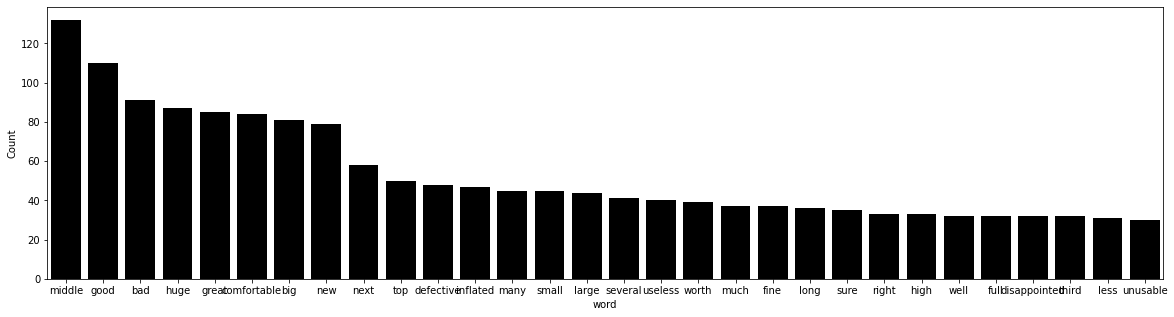

In [13]:
# 11 Create chart frequent words for 1 star reviews
reviews_1star_3 = []
for i in range(len(reviews_1star_2 )):
    reviews_1star_3.append(' '.join(reviews_1star_2[i]))

df_1star['review_body'] = reviews_1star_3

freq_words(df_1star['review_body'], 30)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


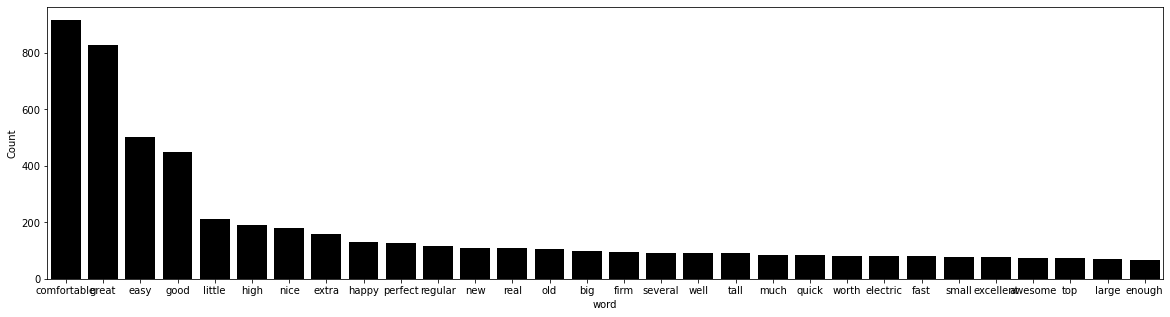

In [14]:
# 12 Create chart frequent words for 5 star reviews
reviews_5stars_3 = []
for i in range(len(reviews_5stars_2 )):
    reviews_5stars_3.append(' '.join(reviews_5stars_2[i]))

df_5stars['reviews'] = reviews_5stars_3

freq_words(df_5stars['reviews'], 30)

### Create Latent Dirichlet Allocation (LDA) model

One application of LDA in machine learning - specifically, topic discovery, a subproblem in natural language processing - is to discover topics in a collection of documents, and then automatically classify any individual document within the collection in terms of how "relevant" it is to each of the discovered topics. A topic is considered to be a set of terms (i.e., individual words or phrases) that, taken together, suggest a shared theme. Souce: Wikipedia

Topic Modelling is different from rule-based text mining approaches that use regular expressions or dictionary based keyword searching techniques. It is an unsupervised approach used for finding and observing the bunch of words (called “topics”) in large clusters of texts. Source: https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

In [15]:
# 13 Import dependencies for LDA model
import gensim
from gensim import corpora

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.wa

In [16]:
# 14 Create the term dictionary of our corpus, unique terms are assigned an index
dictionary_1star = corpora.Dictionary(reviews_1star_2)
dictionary_5stars = corpora.Dictionary(reviews_5stars_2)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# 15 Transform list of reviews into a document term matrix
doc_term_matrix_1star = [dictionary_1star.doc2bow(rev) for rev in reviews_1star_2]
doc_term_matrix_5stars = [dictionary_5stars.doc2bow(rev) for rev in reviews_5stars_2]

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# 16 Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model. In this case we specifified # of topics = 4 and 3 (reassessed after viz)
lda_model_1star = LDA(corpus=doc_term_matrix_1star, id2word=dictionary_1star, num_topics=4, random_state=100,
                chunksize=1000, passes=50)

lda_model_5stars = LDA(corpus=doc_term_matrix_5stars, id2word=dictionary_5stars, num_topics=3, random_state=100,
                chunksize=1000, passes=50)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# 17 Print topics 1 star
lda_model_1star.print_topics()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.034*"inflated" + 0.027*"defective" + 0.025*"new" + 0.023*"next" + 0.021*"slow" + 0.020*"good" + 0.020*"several" + 0.018*"flat" + 0.018*"bad" + 0.017*"much"'),
 (1,
  '0.050*"bad" + 0.034*"great" + 0.033*"big" + 0.027*"middle" + 0.025*"good" + 0.023*"huge" + 0.020*"fine" + 0.015*"comfortable" + 0.014*"useless" + 0.014*"little"'),
 (2,
  '0.075*"middle" + 0.033*"great" + 0.027*"disappointed" + 0.026*"comfortable" + 0.026*"huge" + 0.025*"worth" + 0.025*"new" + 0.016*"well" + 0.015*"right" + 0.015*"old"'),
 (3,
  '0.047*"good" + 0.037*"large" + 0.033*"many" + 0.022*"full" + 0.022*"top" + 0.021*"high" + 0.020*"comfortable" + 0.018*"small" + 0.015*"different" + 0.015*"less"')]

In [20]:
# 18 Print topics 5 stars
lda_model_5stars.print_topics()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.139*"great" + 0.119*"good" + 0.056*"comfortable" + 0.037*"perfect" + 0.024*"small" + 0.019*"awesome" + 0.016*"many" + 0.016*"durable" + 0.016*"convenient" + 0.015*"full"'),
 (1,
  '0.124*"comfortable" + 0.106*"easy" + 0.044*"extra" + 0.035*"nice" + 0.033*"happy" + 0.031*"little" + 0.028*"firm" + 0.022*"inflated" + 0.021*"excellent" + 0.020*"regular"'),
 (2,
  '0.079*"great" + 0.055*"comfortable" + 0.049*"high" + 0.034*"easy" + 0.029*"new" + 0.026*"electric" + 0.025*"old" + 0.024*"quick" + 0.024*"big" + 0.022*"well"')]

### Topics visualization

In [21]:
# 19 Visualize topics for 1 star
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model_1star, doc_term_matrix_1star, dictionary_1star)

vis

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.057859  0.139903       1        1  28.672615
1     -0.051033 -0.002221       2        1  26.880042
3      0.138294 -0.099460       3        1  22.330327
2     -0.145120 -0.038222       4        1  22.117016, topic_info=         Term        Freq       Total Category  logprob  loglift
26     middle  111.000000  111.000000  Default  30.0000  30.0000
168  inflated   40.000000   40.000000  Default  29.0000  29.0000
124       bad   77.000000   77.000000  Default  28.0000  28.0000
75      large   37.000000   37.000000  Default  27.0000  27.0000
53      great   72.000000   72.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
45    useless   12.011296   34.516700   Topic4  -4.3157   0.4532
56       less    8.992303   26.746449   Topic4  -4.6052   0.4188
58      small    8.088066   38.586286   Topic4  -4.7112  -0.0537
22        big    8.665381   69.271302   Topic4  -4.6423  -0.5699
140      long    7.280951   31.186009   Topic4  -4.8163   0.0541

[265 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
111       1  0.641719        able
111       3  0.296178        able
197       2  0.790256    absolute
197       4  0.197564    absolute
484       3  0.797785  acceptable
...     ...       ...         ...
174       1  0.297908       worth
174       4  0.685188       worth
194       4  0.957954   worthless
204       3  0.898193      worthy
524       4  0.596916     youthis

[365 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

In [22]:
# 20 Export to html
lda_model_1star=open('lda_model_1star.html', 'w')
pyLDAvis.save_html(vis, lda_model_1star)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
# 21 Visualize topics for 5 stars
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model_5stars, doc_term_matrix_5stars, dictionary_5stars)

vis

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.014394 -0.196934       1        1  34.223094
0     -0.204872  0.108492       2        1  33.165382
1      0.219267  0.088442       3        1  32.611524, topic_info=        Term        Freq       Total Category  logprob  loglift
24      good  400.000000  400.000000  Default  30.0000  30.0000
7      great  737.000000  737.000000  Default  29.0000  29.0000
21      easy  466.000000  466.000000  Default  28.0000  28.0000
68      high  171.000000  171.000000  Default  27.0000  27.0000
5      extra  143.000000  143.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
56   inflate   34.301504   72.124314   Topic3  -4.5643   0.3773
126     sure   29.665984   56.409812   Topic3  -4.7095   0.4779
52       low   23.770821   50.540113   Topic3  -4.9310   0.3662
6       fast   22.729888   72.294975   Topic3  -4.9758  -0.0366
19      soft   20.722522   52.603434   Topic3  -5.0683   0.1889

[172 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
132       1  0.419699        able
132       3  0.566594        able
298       2  0.950221  additional
248       2  0.962126  adjustable
141       3  0.960183  affordable
...     ...       ...         ...
84        3  0.920351       whole
158       3  0.986022   wonderful
13        1  0.444373       worth
13        2  0.545944       worth
100       2  0.965064       wrong

[166 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [24]:
# 22 Export to html
lda_model_5stars=open('5star_lda.html', 'w')
pyLDAvis.save_html(vis, lda_model_5stars)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


There are 28121 words in the combination of all cells in column reviews for 1-star.


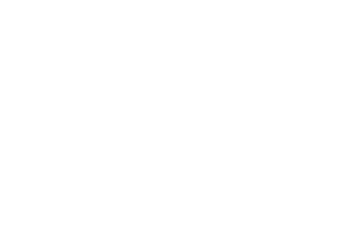

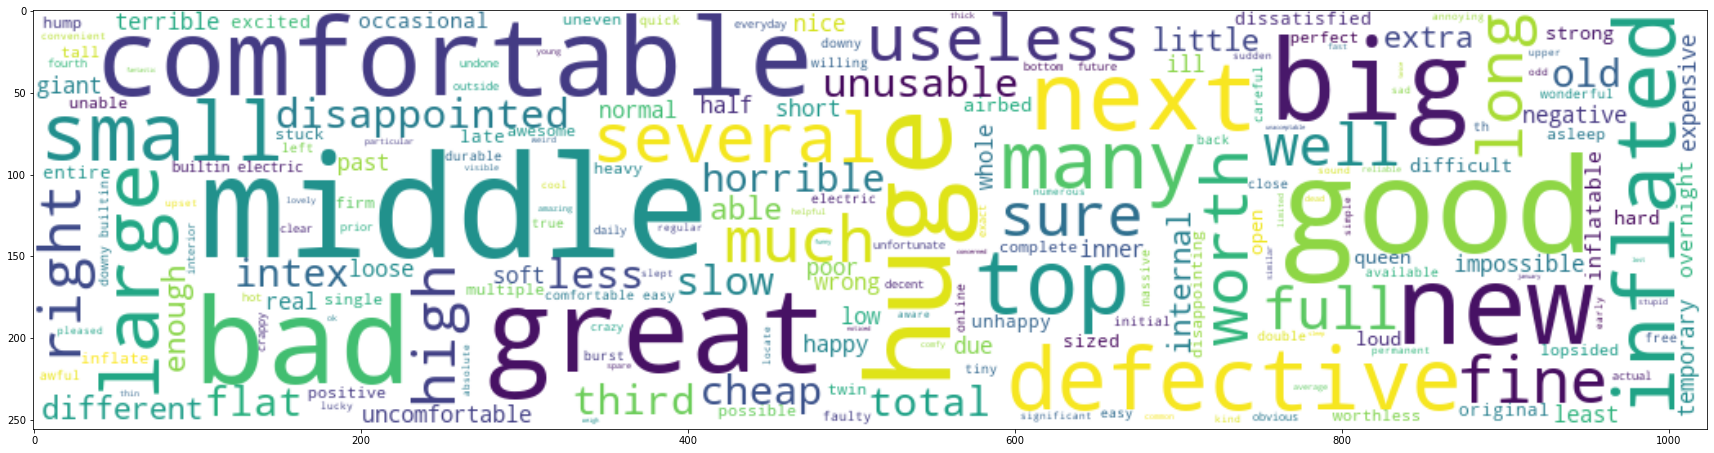

In [26]:
# 23 Create word cloud for 1 star reviews
# Text of all words in column customer reviews

text = " ".join(review for review in df_1star.review_body.astype(str))
print ("There are {} words in the combination of all cells in column reviews for 1-star.".format(len(text)))


# Generate a word cloud image
wordcloud = WordCloud(background_color="white", width=1024, height=256).generate(text)

# Display the generated image:
# the matplotlib way:

plt.axis("off")
plt.figure( figsize=(30,10))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


There are 603244 words in the combination of all cells in column reviews for 5-stars.


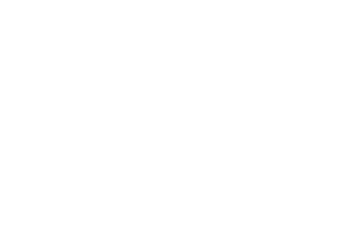

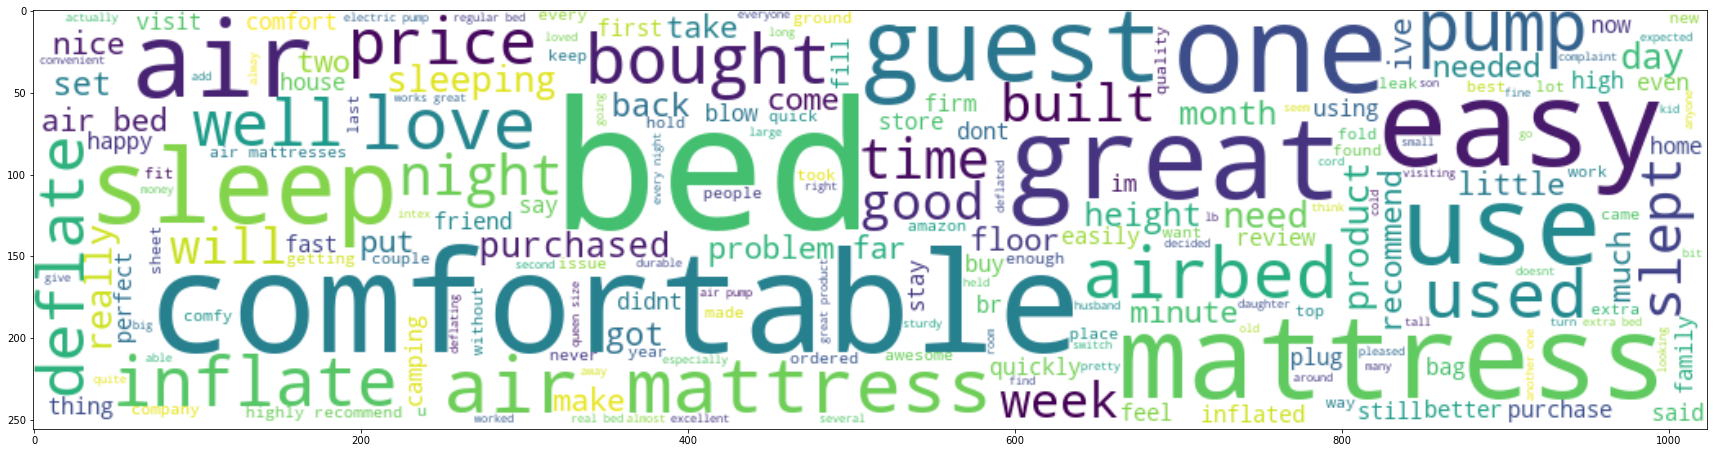

In [27]:
# 26 Create word cloud for 5 star reviews
# Text of all words in column customer reviews

text = " ".join(review for review in df_5stars.review_body.astype(str))
print ("There are {} words in the combination of all cells in column reviews for 5-stars.".format(len(text)))


# Generate a word cloud image
wordcloud = WordCloud(background_color="white", width=1024, height=256).generate(text)

# Display the generated image:
# the matplotlib way:

plt.axis("off")
plt.figure( figsize=(30,10))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()